## Case: finding similar listings based on the images and the data we have about the restaurants. 
This information can be used to recommend restaurants to people if they give a similar restaurant a good rating. 

### When trying to compare how similar images are, there are different approaches to do this.

- use the encoding side of an autoencoder
- Use a model that extracts image features

1. Using an autoencoder

In [1]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd

# Load images
img_size = 128
channels = 1
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2, 
    horizontal_flip=True,
    validation_split=0.2,
    rotation_range=20)

path_to_images = 'D:\School\Master\Machinaal Leren\git\Machine-learning\\images'

training_set = train_datagen.flow_from_directory(
    path_to_images,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'input',
    subset = 'training',
    classes=['interiors','food'],
    color_mode='grayscale',
    shuffle=True)

validation_set = train_datagen.flow_from_directory(
    path_to_images,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'input',
    subset = 'validation',
    classes=['interiors','food'],
    color_mode='grayscale',
    shuffle=False)
     

Found 208 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [2]:
# Define the autoencoder
input_model = Input(shape=(img_size, img_size, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

# Fit the model
history = autoencoder.fit(
          training_set,
          batch_size=batch_size,
          epochs=10,
          validation_data=validation_set,
          shuffle=True)


                                       

Epoch 1/10
7/7 [==============================] - 40s 5s/step - loss: 0.0890 - val_loss: 0.2068
Epoch 2/10
7/7 [==============================] - 29s 4s/step - loss: 0.0517 - val_loss: 0.1692
Epoch 3/10
7/7 [==============================] - 29s 4s/step - loss: 0.0467 - val_loss: 0.1121
Epoch 4/10
7/7 [==============================] - 29s 4s/step - loss: 0.0438 - val_loss: 0.0883
Epoch 5/10
7/7 [==============================] - 29s 4s/step - loss: 0.0403 - val_loss: 0.0589
Epoch 6/10
7/7 [==============================] - 28s 4s/step - loss: 0.0399 - val_loss: 0.0531
Epoch 7/10
7/7 [==============================] - 27s 4s/step - loss: 0.0384 - val_loss: 0.0502
Epoch 8/10
7/7 [==============================] - 29s 4s/step - loss: 0.0375 - val_loss: 0.0504
Epoch 9/10
7/7 [==============================] - 29s 4s/step - loss: 0.0364 - val_loss: 0.0523
Epoch 10/10
7/7 [==============================] - 28s 4s/step - loss: 0.0354 - val_loss: 0.0519


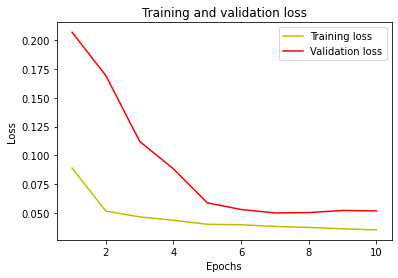

In [87]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
print (validation_set.image_shape)

(128, 128, 1)


In [85]:
filenames = validation_set.filenames
encoded_imgs = autoencoder.predict(validation_set)
print(encoded_imgs.shape)


2/2 [==============================] - 3s 822ms/step
(51, 128, 128, 3)


In [83]:
latent_space_model = Model(
                      autoencoder.input, 
                      autoencoder.get_layer('latent_space').output)
latent_space_model.save('D:\School\Master\Machinaal Leren\git\Machine-learning\latent_space_model.h5')

In [73]:
# Load all images and predict them with the latent space model
import os
X = []
indices = []

for i in range(len(os.listdir('D:\School\Master\Machinaal Leren\git\Machine-learning\\images\\food'))):
  try:
    img_name = os.listdir('D:\School\Master\Machinaal Leren\git\Machine-learning\\images\\food')[i]
    img = load_img('D:\School\Master\Machinaal Leren\git\Machine-learning\\images\\food\\{}'.format(img_name), 
                   target_size = (128, 128), color_mode='grayscale')
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    #pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

  except Exception as e:
    print(img_name)
    print(e)

    # Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}
pickle.dump(embeddings, 
            open('D:\School\Master\Machinaal Leren\git\Machine-learning\image_embeddings.pickle', 'wb'))

1/1 [==============================] - 0s 32ms/step


In [74]:
print (X[1])
print (indices[1])

[[ -5.404869   -1.2809682   4.58618    -5.333594   -6.9124618 -10.822854
  -17.493086  -49.95495   -15.368852   24.204348  -62.805614  -76.25767
   29.026361   38.419037  -16.30563    41.3935   ]]
694642_2.jpg


In [54]:
def eucledian_distance(x,y):
    eucl_dist = np.linalg.norm(x - y)
    return eucl_dist

In [75]:
def show_image(img_path):
    image = load_img(img_path, target_size=(128, 128))
    plt.imshow(image)
    plt.show()
    

In [76]:
original = X[0]
original_path = indices[1]
min_dist = 999999999999999999999999999
distance_from_original = {}
for i in range(len(X)):
    distance_from_original[indices[i]] = eucledian_distance(original, X[i])
    
dichtstbijzijnde = min(distance_from_original, key=distance_from_original.get)
print(original_path)
print(dichtstbijzijnde)

        



# for i in range(10):
#     dichtstbijzijnde = min(distance_from_original, key=distance_from_original.get)
#     print('Distance: {}'.format(distance_from_original[dichtstbijzijnde]))
#     show_image('D:\School\Master\Machinaal Leren\git\Machine-learning\\images\\food\\{}'.format(dichtstbijzijnde))
#     distance_from_original.pop(dichtstbijzijnde)
        

694642_2.jpg
694642_0.jpg


original image:


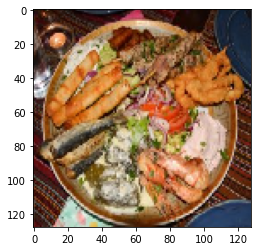

,afstand,restaurant id
694642_0.jpg,0.000000,694642
694642_4.jpg,55.306343,694642
694642_7.jpg,65.234978,694642
740658_2.jpg,66.905632,740658
740632_0.jpg,73.694427,740632
740596_8.jpg,75.157585,740596
740622_7.jpg,77.873398,740622
740622_0.jpg,78.162338,740622
740637_0.jpg,78.162338,740637
740622_4.jpg,79.984924,740622


In [82]:
print('original image:')
show_image('D:\School\Master\Machinaal Leren\git\Machine-learning\\images\\food\\{}'.format(original_path))

# find restaurants based on similar images
dist_df = pd.DataFrame(distance_from_original, index=['afstand']).T.sort_values(by='afstand', ascending=True).head(10)
dist_df['restaurant id'] = dist_df.index.str.split('_').str[0]
dist_df